### Preparation

In [1]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

from train_arg_parser import get_args_parser
from models.model_configs import instantiate_model

from training.eval_loop import eval_model
from train import get_data_loader

# redirect logging in this notebook
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = []
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)
handler.setFormatter(logging.Formatter('%(asctime)s - %(filename)s - %(levelname)s: %(message)s'))
logger.addHandler(handler)

### Load checkpoint

In [22]:
# Parse arguments
args = get_args_parser().parse_args([])
args.use_edm_aug = True
args.distributed = False
args.output_dir = "./tmp"
args.dataset = "shrimp"
args.batch_size = 64
args.lr = 0.0006
args.eval_frequency = 50
args.epochs = 400
args.log_per_step = 100
args.tr_sampler = "v1"
args.P_mean_t = -0.6
args.P_std_t = 1.6
args.P_mean_r = -4.0
args.P_std_r = 1.6
args.warmup_epochs = 200
args.norm_p = 0.75
args.ratio = 0.75
args.dropout = 0.2
args.sat_files_path = "/mnt/ssd_1/yghu/Data/dataset/noradar"
args.radar_files_path = "/mnt/ssd_1/yghu/Data/dataset/radar/71"
args.coverage_threshold = 0.1
args.seed = 42
args.block_size = 96
args.split_ratio = (0.7,0.2,0.1)
args.retrieve_dataset = True

chkpt = "tmp/checkpoint-last.pth"

# If not having downloaded the checkpoint:
%pip install -q gdown
import gdown
import os
if not os.path.exists(chkpt):
    gdown.download(f"https://drive.google.com/uc?id=1Ev9aZdt7hNVkOfaTQ7rrLAqs3jA_vnvj", output=chkpt, quiet=False)

checkpoint = torch.load(chkpt, map_location="cpu", weights_only=False)

model = instantiate_model(args)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.load_state_dict(checkpoint["model"])
epoch = checkpoint["epoch"] + 1

print('Checkpoint loaded.')

Note: you may need to restart the kernel to use updated packages.
Checkpoint loaded.


### Generation Demo

In [87]:
# get sat conditons
from models.DatasetBuilder import DatasetBuilder
from models.dataset import SatelliteDataset
import torch

datasetbuilder = DatasetBuilder(
    sat_path=args.sat_files_path,
    radar_path=args.radar_files_path,
    start_date=args.start_date,
    end_date=args.end_date,
    max_folders=args.max_folders,
    history_frames=args.history_frames,
    future_frame=args.future_frame,
    refresh_rate=args.refresh_rate,
    coverage_threshold=args.coverage_threshold,
    seed=args.seed
)
dataset_pkl_name = "dataset_filelist.pkl"
dataset_pkl_path = os.path.join(args.output_dir, dataset_pkl_name)
if args.retrieve_dataset:
    _, _, test_files = datasetbuilder.load_filelist(dataset_pkl_path)
    logger.info(f"Loaded existing dataset from {dataset_pkl_path}")
else:
    _, _, test_files = datasetbuilder.build_filelist_by_blocks(
        save_dir=args.output_dir,
        file_name=dataset_pkl_name,
        block_size=args.block_size,
        split_ratio=args.split_ratio,
    )
    logger.info(f"Built new dataset to {dataset_pkl_path}")
test_dataset = SatelliteDataset(files=test_files, sat_dim=args.sat_dim, transform=None)
print(f"[Test Dataset] Files: {len(test_files)}, Dataset length: {len(test_dataset)}")
dataset = test_dataset
data_loader = torch.utils.data.DataLoader(
    dataset,
    sampler=None,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    pin_memory=args.pin_mem,
    drop_last=False,  # for FID evaluation, we want to keep all samples
)

2025-10-27 18:17:07,969 - DatasetBuilder.py - INFO: Loaded dataset from: ./tmp/dataset_filelist.pkl
2025-10-27 18:17:07,972 - 2629501391.py - INFO: Loaded existing dataset from ./tmp/dataset_filelist.pkl


[Test Dataset] Files: 384, Dataset length: 384


In [88]:
conds, *_ = next(iter(data_loader))
conds = conds.permute(0, 3, 1, 2).to(args.device, non_blocking=True)

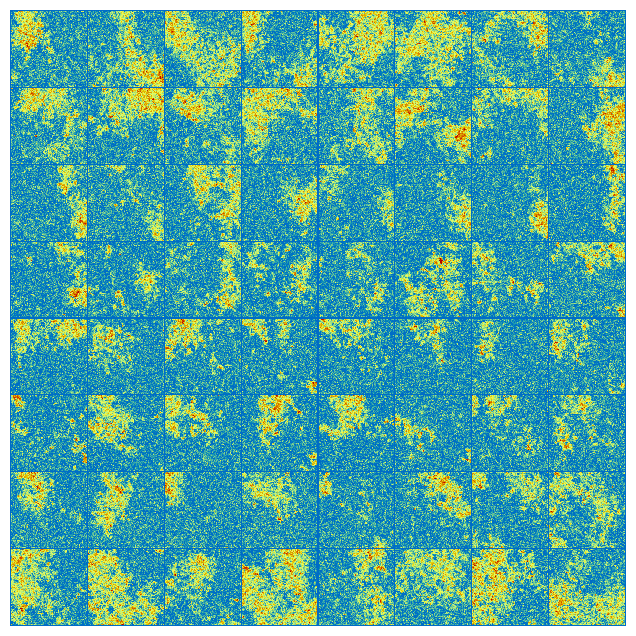

In [89]:
import numpy as np
import cmweather
nrow = 8
num_samples = nrow**2
torch.manual_seed(0)
with torch.no_grad():
    imgs = model.sample(cond=conds, samples_shape=(num_samples, 1, 128, 128), net=model.net_ema1, device=device)

imgs = torch.clamp(imgs * 0.5 + 0.5, min=0.0, max=1.0)
imgs = torch.floor(imgs * 60)
imgs = imgs.to(torch.uint8)

grid = make_grid(imgs, nrow=nrow).permute(1, 2, 0).cpu().numpy()
grid = grid[:, :,2]
cmap="HomeyerRainbow"
plt.figure(figsize=(nrow, nrow))
#plt.imshow(np.ma.masked_less(grid, 1), cmap=cmap, vmin=0, vmax=60, interpolation='none')
plt.imshow(grid, cmap=cmap, vmin=0, vmax=60, interpolation='none')
plt.axis('off')
plt.show()


In [79]:
print(conds[:,0:3,:,:].shape)

torch.Size([64, 3, 128, 128])


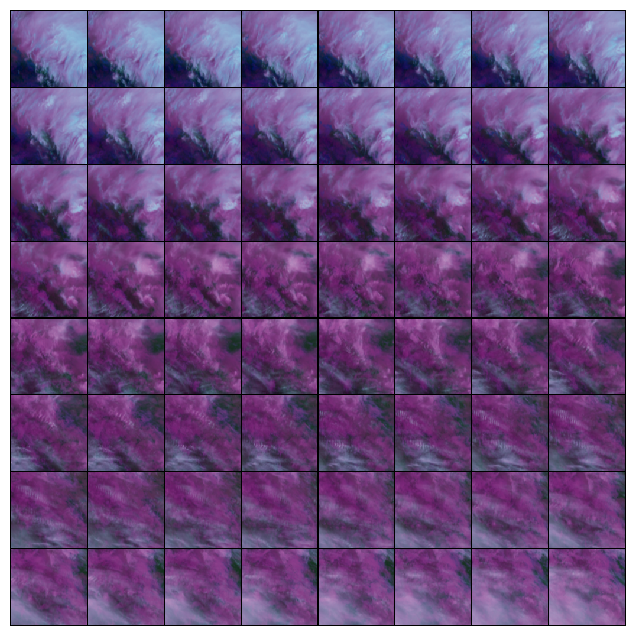

In [90]:

conds = torch.clamp(conds * 0.5 + 0.5, min=0.0, max=1.0)
#conds = torch.floor(conds * 255)
#conds = conds.to(torch.uint8)
grid = make_grid(conds[:,0:3,:,:], nrow=nrow).permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(nrow, nrow))
plt.imshow(grid, interpolation='none')
plt.axis('off')
plt.show()

### Evaluate FID

In [4]:
args.batch_size = 128
args.compute_fid = True
args.seed = 0

data_loader_fid = get_data_loader(args, is_for_fid=True)
net_eval = model.net_ema1
eval_stats = eval_model(
    model,
    net_eval,
    data_loader_fid,
    device,
    epoch=epoch,
    args=args,
    suffix=f'_ema{model.net_ema.ema_decay}',
)
print(f"FID_ema{net_eval.ema_decay}: {eval_stats['fid']}")

2025-07-24 12:15:04,999 - train.py - INFO: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
           )
2025-07-24 12:15:05,000 - train.py - INFO: Intializing DataLoader


2025-07-24 12:15:05,001 - train.py - INFO: <torch.utils.data.distributed.DistributedSampler object at 0x7fae860c5070>
2025-07-24 12:15:13,748 - eval_loop.py - INFO: Evaluating: current batch 128,  [1280/50000], running fid 37.64066696166992
2025-07-24 12:15:18,896 - eval_loop.py - INFO: Evaluating: current batch 128,  [2560/50000], running fid 20.778017044067383
2025-07-24 12:15:24,031 - eval_loop.py - INFO: Evaluating: current batch 128,  [3840/50000], running fid 14.657516479492188
2025-07-24 12:15:29,190 - eval_loop.py - INFO: Evaluating: current batch 128,  [5120/50000], running fid 11.467696189880371
2025-07-24 12:15:34,439 - eval_loop.py - INFO: Evaluating: current batch 128,  [6400/50000], running fid 9.555079460144043
2025-07-24 12:15:39,678 - eval_loop.py - INFO: Evaluating: current batch 128,  [7680/50000], running fid 8.230422973632812
2025-07-24 12:15:44,891 - eval_loop.py - INFO: Evaluating: current batch 128,  [8960/50000], running fid 7.365575313568115
2025-07-24 12:15:5

FID_ema0.99995: 2.796400308609009
